# Analyse des données vélo à Paris

Chargement des packages nécessaires

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import glob


# Chargement des données via l'API (à ignorer pour le moment)


DATA_DIR = "data"
CSV_FILE = f"{DATA_DIR}/velo_paris.csv"
PICKLE_FILE = f"{DATA_DIR}/velo_paris.pkl"

#DATA_URL = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/exports/csv?lang=fr&timezone=Europe%2FParis&use_labels=true&delimiter=%3B&rows=1000000"

os.makedirs(DATA_DIR, exist_ok=True)

if os.path.exists(PICKLE_FILE):
    print("Chargement du DataFrame depuis le pickle...")
    df = pd.read_pickle(PICKLE_FILE)
elif os.path.exists(CSV_FILE):
    print("Chargement du CSV local...")
    df = pd.read_csv(CSV_FILE, sep=';')
    df.to_pickle(PICKLE_FILE)
else:
    print("Téléchargement du CSV depuis OpenData Paris...")
    df = pd.read_csv(DATA_URL, sep=';')
    df.to_csv(CSV_FILE, index=False)
    df.to_pickle(PICKLE_FILE)

df.head()



df[['Comptage horaire']].describe()

# Partie 1 : travail sur les données 2018-2024

Chargement des données 2018-2024

In [ ]:
PARQUET_HISTORIQUE = f"{DATA_DIR}/velo_paris_historique.parquet"

if os.path.exists(PARQUET_HISTORIQUE):
    print("Chargement du DataFrame historique depuis parquet...")
    df_historique = pd.read_parquet(PARQUET_HISTORIQUE)
else:
    print("Combinaison des fichiers historiques...")
    fichiers = glob.glob(f"{DATA_DIR}/*comptage*.csv")
    
    df_historique_list = []
    for fichier in fichiers:
        print(f"  Chargement de {fichier}...")
        temp_df = pd.read_csv(fichier, sep=';')
        df_historique_list.append(temp_df)
    
    df_historique = pd.concat(df_historique_list, ignore_index=True)
    
    # Sauvegarder en parquet (format compressé)
    df_historique.to_parquet(PARQUET_HISTORIQUE, compression='gzip')

df_historique.head()

Combinaison des fichiers historiques...
  Chargement de data/2019_comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2024-comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2018_comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2021_comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2020_comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2023-comptage-velo-donnees-sites-comptage.csv...
  Chargement de data/2022_comptage-velo-donnees-sites-comptage.csv...
Sauvegarde en parquet...
Total de lignes : 23916059


,Identifiant du point de comptage,Nom du point de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du point de comptage,Lien vers photo du point de comptage,Coordonnées géographiques,"Identifiant du point de comptage,""Nom du point de comptage"",""Comptage horaire"",""Date et heure de comptage"",""Lien vers photo du point de comptage"",""Coordonnées géographiques"""
0,100003096.0,97 Avenue Denfert Rochereau SO-NE,8.0,2019-04-15T11:45:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",NaN
1,100003096.0,97 Avenue Denfert Rochereau SO-NE,7.0,2019-04-16T07:30:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",NaN
2,100003096.0,97 Avenue Denfert Rochereau SO-NE,17.0,2019-04-16T09:30:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",NaN
3,100003096.0,97 Avenue Denfert Rochereau SO-NE,9.0,2019-04-16T12:15:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",NaN
4,100003096.0,97 Avenue Denfert Rochereau SO-NE,9.0,2019-04-16T14:00:00+02:00,2012-02-22,https://www.eco-visio.net/Photos/100003096/157...,"48.834695,2.332968",NaN


Évolution de l'usage du vélo par mois et arrondissement entre 2018 et 2024

/tmp/ipykernel_11957/400368498.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_historique['mois'] = df_historique['date'].dt.to_period('M')  # pour grouper par mois
Skipping field geom_x_y: unsupported OGR type: 3


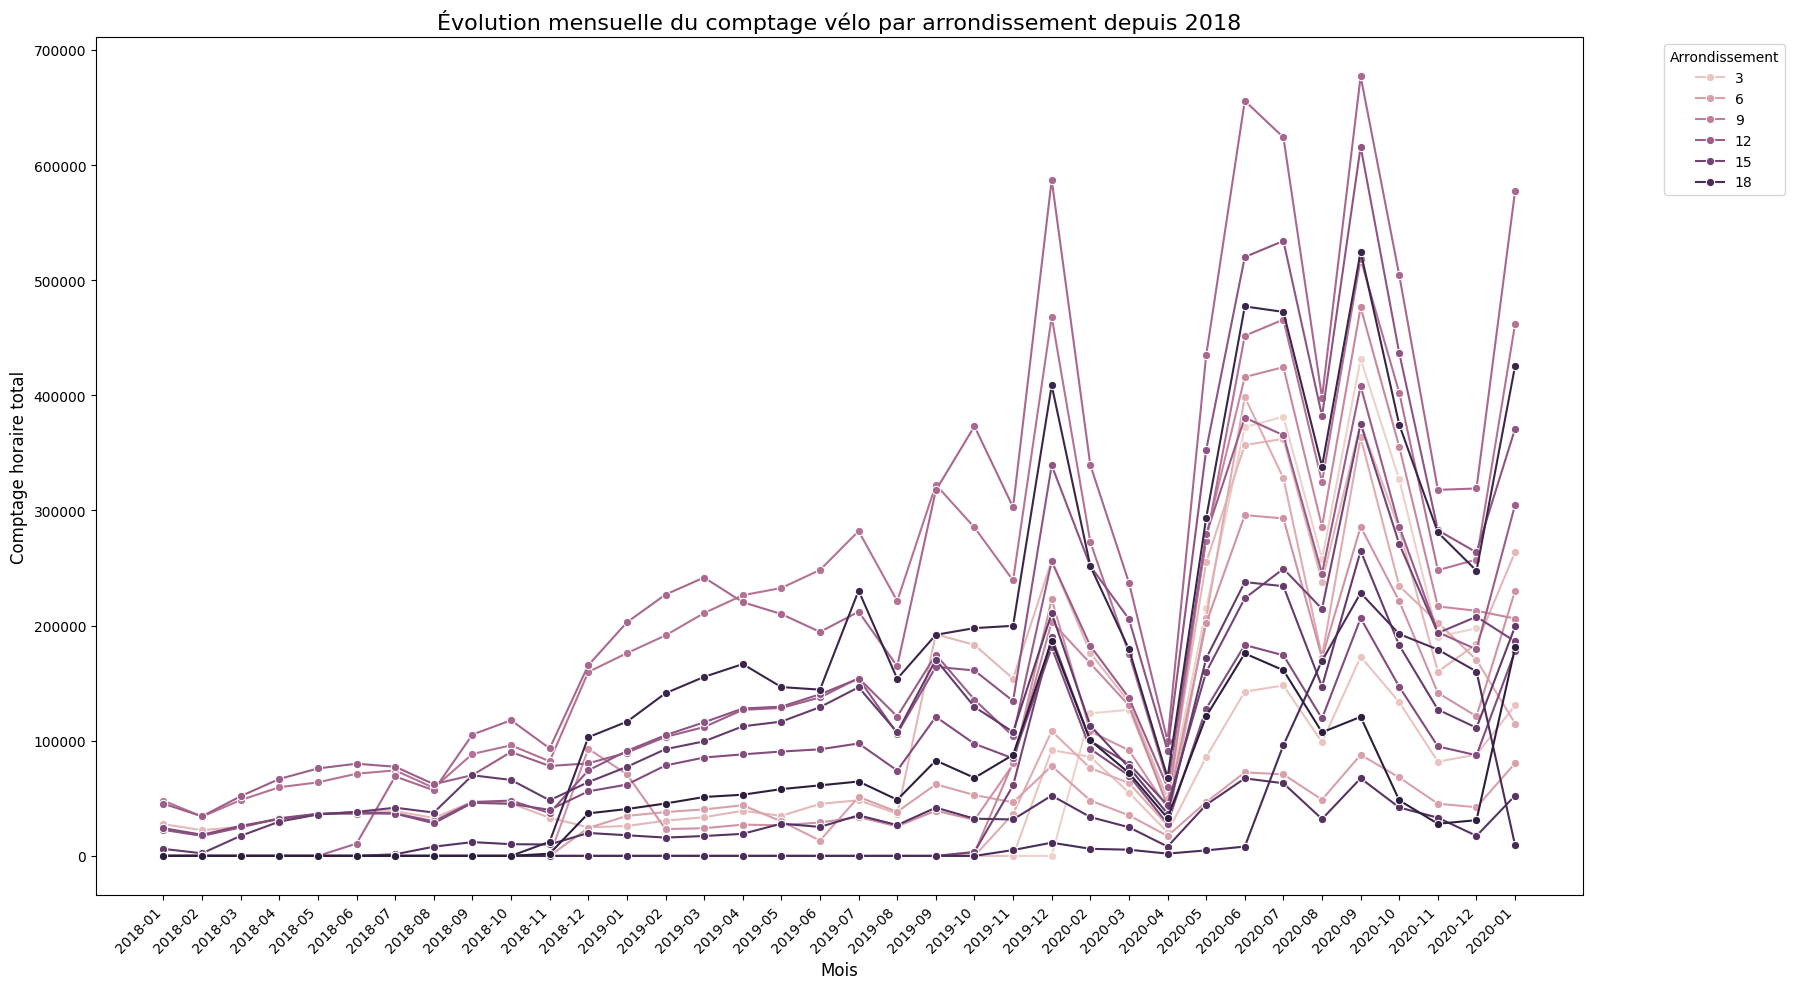

In [13]:
# --- Préparer les colonnes date/mois ---
df_historique['date'] = pd.to_datetime(df_historique['Date et heure de comptage'], errors='coerce', utc=True)
df_historique = df_historique.dropna(subset=['date'])  # enlever les lignes avec date invalide
df_historique = df_historique[df_historique['date'].dt.year >= 2018]  # filtrer depuis 2018
df_historique['mois'] = df_historique['date'].dt.to_period('M')  # pour grouper par mois

# --- Extraire latitude et longitude depuis 'Coordonnées géographiques' ---
df_historique[['lat', 'lon']] = df_historique['Coordonnées géographiques'].str.split(',', expand=True).astype(float)
gdf_velo = gpd.GeoDataFrame(df_historique, geometry=gpd.points_from_xy(df_historique['lon'], df_historique['lat']), crs="EPSG:4326")

# --- Charger les arrondissements depuis le GeoJSON officiel ---
arrondissements = gpd.read_file(
    "https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson"
)
arrondissements = arrondissements.to_crs(epsg=4326)  # même CRS 

# --- Spatial join pour attribuer l'arrondissement à chaque point ---
gdf_velo = gpd.sjoin(gdf_velo, arrondissements[['geometry', 'c_ar']], how="left", predicate="intersects")
gdf_velo.rename(columns={'c_ar':'arrondissement'}, inplace=True)

# --- Convertir 'mois' en string pour le groupby ---
gdf_velo['mois_str'] = gdf_velo['mois'].astype(str)

# --- Agrégation mensuelle par arrondissement ---
df_monthly = gdf_velo.groupby(['arrondissement', 'mois_str'])['Comptage horaire'].sum().reset_index()
df_monthly.rename(columns={'mois_str': 'mois'}, inplace=True)

# --- Graphique ---
plt.figure(figsize=(18,10))
sns.lineplot(data=df_monthly, x='mois', y='Comptage horaire', hue='arrondissement', marker="o")
plt.title("Évolution mensuelle du comptage vélo par arrondissement depuis 2018", fontsize=16)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Comptage horaire total", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Arrondissement", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()